


#Mount Google Drive

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries

In [6]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import SpatialDropout2D, GaussianNoise
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, precision_recall_fscore_support
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import pickle

In [ ]:
print(tf.__version__)

2.17.0


#Define the directory to save the models



In [7]:
# Define the directory to save the models
base_dir = '/content/drive/My Drive/MENG/ANN'
os.makedirs(base_dir, exist_ok=True)

checkpoint_dir = os.path.join(base_dir, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

history_dir = os.path.join(base_dir, 'history')
os.makedirs(history_dir, exist_ok=True)


#Download Lung Mask Image Dataset from Kagle

In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload Kaggle API token
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Create .kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d newra008/lung-mask-image-dataset

# Unzip the dataset
!unzip lung-mask-image-dataset.zip -d lung_mask_dataset

Streaming output truncated to the last 5000 lines.
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9309.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_931.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9310.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9311.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9312.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9313.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9314.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9315.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9316.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9317.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9318.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_9319.jpeg  
  inflating: lung_mask_dataset/ChestXray/train/mask/cxrmask_932.jpeg  
  inflating: lu

In [ ]:
#Define directories
train_image_dir = 'lung_mask_dataset/ChestXray/train/image'
train_mask_dir = 'lung_mask_dataset/ChestXray/train/mask'
val_image_dir = 'lung_mask_dataset/ChestXray/val/image'
val_mask_dir = 'lung_mask_dataset/ChestXray/val/mask'
test_image_dir = 'lung_mask_dataset/ChestXray/test/image'
test_mask_dir = 'lung_mask_dataset/ChestXray/test/mask'

# Define image size and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8  # Start with a smaller batch size

# Function to create a custom data generator with sampling and augmentation
def custom_data_generator(image_dir, mask_dir, batch_size, image_size, augment=False):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    # Define ImageDataGenerator for augmentation
    if augment:
        image_datagen = ImageDataGenerator(
            # rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
        mask_datagen = ImageDataGenerator(
            # rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
    else:
        image_datagen = ImageDataGenerator(rescale=1./255)
        mask_datagen = ImageDataGenerator(rescale=1./255)

    while True:
        sampled_indices = random.sample(range(len(image_filenames)), batch_size)
        img_batch = [image_filenames[i] for i in sampled_indices]
        mask_batch = [mask_filenames[i] for i in sampled_indices]

        images = []
        masks = []

        for img, mask in zip(img_batch, mask_batch):
            img_path = os.path.join(image_dir, img)
            mask_path = os.path.join(mask_dir, mask)

            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')

            img = img_to_array(img)
            mask = img_to_array(mask)

            if augment:
                seed = random.randint(0, 10000)
                img = image_datagen.random_transform(img, seed=seed)
                mask = mask_datagen.random_transform(mask, seed=seed)

            #normalization
            img = img / 255.0
            mask = mask / 255.0

            images.append(img)
            masks.append(mask)

        yield np.array(images), np.array(masks)

# Create the data generators with sampling and augmentation for training
train_generator = custom_data_generator(train_image_dir, train_mask_dir, BATCH_SIZE, IMAGE_SIZE, augment=True)
val_generator = custom_data_generator(val_image_dir, val_mask_dir, BATCH_SIZE, IMAGE_SIZE)
test_generator = custom_data_generator(test_image_dir, test_mask_dir, BATCH_SIZE, IMAGE_SIZE)

#Define U-Net Model

In [ ]:

def unet_model(input_size=(256, 256, 1), learning_rate=1e-4, dropout_rate=0.5):
    inputs = layers.Input(input_size)

    # Adding Gaussian noise
    noise = layers.GaussianNoise(0.1)(inputs)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(noise)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = SpatialDropout2D(dropout_rate)(pool1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(drop1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = SpatialDropout2D(dropout_rate)(pool2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(drop2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = SpatialDropout2D(dropout_rate)(pool3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(drop3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = SpatialDropout2D(dropout_rate)(pool4)

    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(drop4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    # Decoder
    up6 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    up8 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    up9 = layers.Conv2D(32, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), 'Precision', 'Recall', tf.keras.metrics.AUC()])

    return model

model = unet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 256, 256, 1)          0         ['input_1[0][0]']             
 ise)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['gaussian_noise[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']          

#Define Callbacks for Model Checkpoints

In [ ]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'unet_model_checkpoint_epoch_{epoch:02d}.h5'),
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

callbacks = [checkpoint_callback, reduce_lr, early_stopping]


#Load the Latest Checkpoint

In [ ]:
# Find the latest checkpoint
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('unet_model_checkpoint_epoch_')]
checkpoints.sort()

initial_epoch = 0
if checkpoints:
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
    initial_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0])
    print(f"Loading weights from: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
else:
    print("No checkpoints found. Starting training from scratch.")


Loading weights from: /content/drive/My Drive/MENG/ANN/checkpoints/unet_model_checkpoint_epoch_50.h5


#Train the Model

In [ ]:
# Determine steps per epoch for generators
train_steps = len(os.listdir(train_image_dir)) // BATCH_SIZE
val_steps = len(os.listdir(val_image_dir)) // BATCH_SIZE

# Initialize or load the aggregated history
history_file_path = os.path.join(history_dir, 'training_history.pkl')
if os.path.exists(history_file_path):
    with open(history_file_path, 'rb') as file:
        aggregated_history = pickle.load(file)
else:
    aggregated_history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'mean_io_u': [],
        'val_mean_io_u': [],
        'precision': [],
        'val_precision': [],
        'recall': [],
        'val_recall': [],
        'auc': [],
        'val_auc': [],
    }

# Define the number of epochs to train at a time
num_epochs_at_a_time = 1

# Train the model in multiple stages
for epoch in range(initial_epoch, 50, num_epochs_at_a_time):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        epochs=epoch + num_epochs_at_a_time,
        callbacks=callbacks,
        initial_epoch=epoch,
        workers=1,
        use_multiprocessing=False
    )

    # Aggregate the history
    for key in aggregated_history.keys():
        aggregated_history[key].extend(history.history[key])

    # Save the aggregated history to persistent storage after each stage
    with open(history_file_path, 'wb') as file:
        pickle.dump(aggregated_history, file)

# Print the keys in the aggregated history dictionary before saving
# print("Keys in aggregated history before saving:", aggregated_history.keys())

#Save the Final Model Manually

In [ ]:
# Save the final model manually
model.save(os.path.join(base_dir, 'unet_model_final.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Load Saved Model

In [ ]:
# Load the saved model
model = load_model('/content/drive/My Drive/MENG/ANN/unet_model_final.h5')

#Loading and Plotting Training History

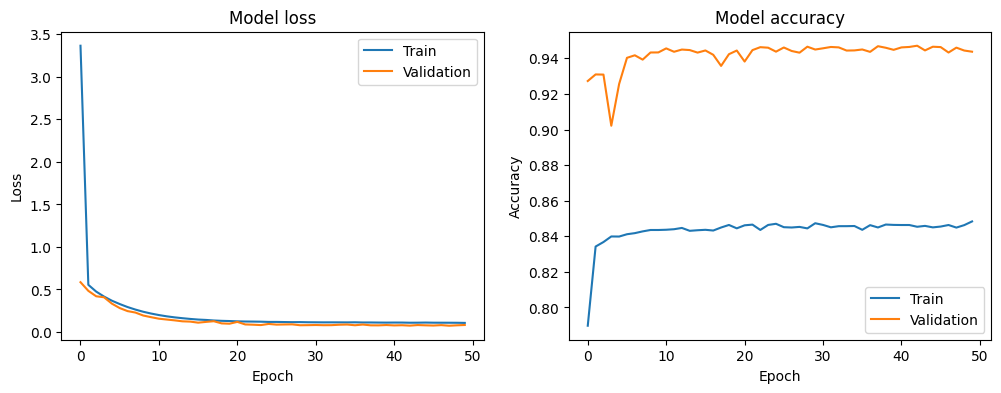

In [ ]:
# Load the training history
history_file_path = '/content/drive/My Drive/MENG/ANN/history/training_history.pkl'
with open(history_file_path, 'rb') as file:
    saved_history = pickle.load(file)

# Create a dummy history object to use with the plotting function
class DummyHistory:
    def __init__(self, history):
        self.history = history

history = DummyHistory(saved_history)

# Print the keys in the history dictionary
# print("Keys in history.history:", history.history.keys())

# Define the plotting function
def plot_training_history(history):
    if 'loss' in history.history and 'val_loss' in history.history and 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.figure(figsize=(12, 4))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')  # Move the legend to the bottom right

        plt.show()
    else:
        print("Required keys are missing in the history object")

# Plot the training history
plot_training_history(history)

#Evaluate the Model

In [ ]:
# Evaluate the model using model.evaluate
test_steps = len(os.listdir(test_image_dir)) // BATCH_SIZE
results = model.evaluate(test_generator, steps=test_steps)

# # Print the results
# print(f'Loss: {results[0]:.4f}')
# print(f'Accuracy: {results[1]:.4f}')
# print(f'MeanIoU: {results[2]:.4f}')
# print(f'Precision: {results[3]:.4f}')
# print(f'Recall: {results[4]:.4f}')
# print(f'AUC (model.evaluate): {results[5]:.4f}')

# Create a DataFrame to display the results
metrics = ['Loss', 'Accuracy', 'MeanIoU', 'Precision', 'Recall', 'AUC (model.evaluate)']
results_df = pd.DataFrame(data={'Metric': metrics, 'Value': results})

# Display the DataFrame as a table
print(results_df)

264/264 [==============================] - 102s 380ms/step - loss: 0.0615 - accuracy: 0.9540 - mean_io_u: 0.3852 - precision: 0.9874 - recall: 0.9195 - auc: 0.9904
                 Metric     Value
0                  Loss  0.061530
1              Accuracy  0.953972
2               MeanIoU  0.385180
3             Precision  0.987444
4                Recall  0.919501
5  AUC (model.evaluate)  0.990424


#Reinitialize the Test Generator

In [ ]:
# Reinitialize the test generator
test_generator = custom_data_generator(test_image_dir, test_mask_dir, BATCH_SIZE, IMAGE_SIZE)

#Custom Metric Calculations

1/1 [==============================] - 0s 361ms/step
Confusion Matrix:
                 Predicted Positive  Predicted Negative
Actual Positive           102883876              877213
Actual Negative              618257            34032686

Other Metrics:
             Metric     Value
0         Precision  0.974872
1            Recall  0.982158
2          F1 Score  0.978501
3       Specificity  0.991546
4               AUC  0.986852
5               IoU  0.957907
6  Dice Coefficient  0.978501

ROC Curve


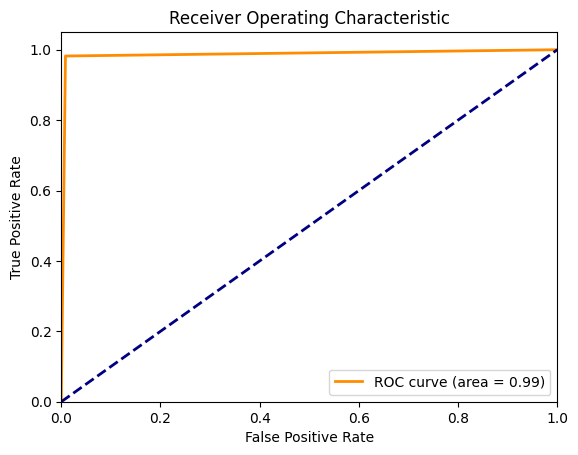

In [ ]:
# Define metrics
def iou(y_true, y_pred):
    intersection = np.sum((y_true * y_pred) > 0.5)
    union = np.sum((y_true + y_pred) > 0.5)
    return intersection / union

def dice_coefficient(y_true, y_pred):
    intersection = np.sum((y_true * y_pred) > 0.5)
    return 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred))

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp)

def flatten_and_binarize(y_true, y_pred):
    y_true_flat = (y_true > 0.5).astype(int).flatten()
    y_pred_flat = (y_pred > 0.5).astype(int).flatten()
    return y_true_flat, y_pred_flat

def calculate_metrics(y_true, y_pred):
    y_true_flat, y_pred_flat = flatten_and_binarize(y_true, y_pred)

    cm = confusion_matrix(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    spec = specificity(y_true_flat, y_pred_flat)
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
    roc_auc = auc(fpr, tpr)

    iou_score = iou(y_true_flat, y_pred_flat)
    dice_score = dice_coefficient(y_true_flat, y_pred_flat)

    return cm, precision, recall, f1, spec, fpr, tpr, roc_auc, iou_score, dice_score

# Example of evaluating the model using custom metrics
def evaluate_model(model, test_generator, test_steps):
    # Collect predictions and true masks
    all_true = []
    all_preds = []

    for _ in range(test_steps):
        test_images, test_masks = next(test_generator)
        preds = model.predict(test_images)

        all_true.extend(test_masks)
        all_preds.extend(preds)

    # Convert lists to numpy arrays
    all_true = np.array(all_true)
    all_preds = np.array(all_preds)

    # Calculate custom metrics
    metrics = calculate_metrics(all_true, all_preds)

    # Print metrics
    # Create and display the labeled confusion matrix DataFrame
    cm_df = pd.DataFrame(metrics[0],
                         index=['Actual Positive', 'Actual Negative'],
                         columns=['Predicted Positive', 'Predicted Negative'])

    # Create a DataFrame for the rest of the metrics with two columns: 'Metric' and 'Value'.
    metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Specificity', 'AUC', 'IoU', 'Dice Coefficient'],
    'Value': [metrics[1], metrics[2], metrics[3], metrics[4], metrics[7], metrics[8], metrics[9]]})

    print("Confusion Matrix:")
    print(cm_df)

    print("\nOther Metrics:")
    print(metrics_df)

    print('\nROC Curve')
    # Plot ROC Curve
    plt.figure()
    plt.plot(metrics[5], metrics[6], color='darkorange', lw=2, label=f'ROC curve (area = {metrics[7]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(model, test_generator, test_steps)

#Plot Sample Prediction

1/1 [==============================] - 0s 367ms/step


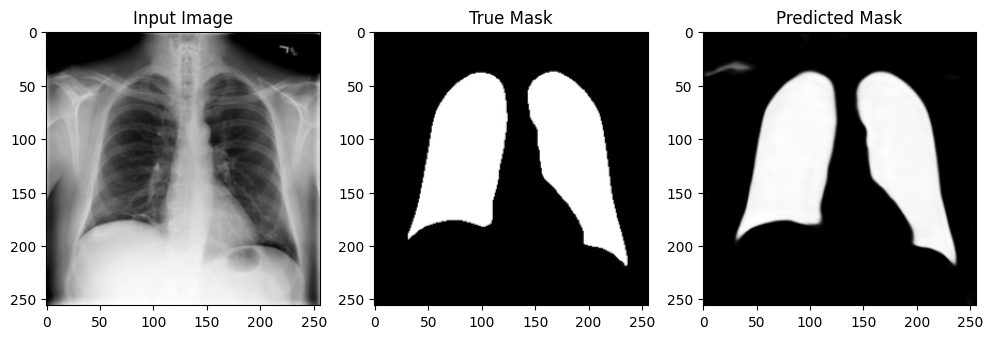

In [ ]:
# Function to plot a sample
def plot_sample(image, mask, prediction):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction[:, :, 0], cmap='gray')

    plt.show()


# Obtain a batch of test images and masks from the test generator
test_images, test_masks = next(test_generator)

# Make predictions on the test images
preds = model.predict(test_images)

# Plot a sample from the test set
plot_sample(test_images[5], test_masks[5], preds[5])